In [ ]:
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
from scipy.special import roots_legendre, eval_legendre
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import discretize
import  os
import json
from PIL import Image
import seaborn as sns
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import ipywidgets as widgets
eps = np.finfo(float).eps

In [ ]:
import empymod
from masa_utils import PsuedoLog
from masa_utils import Pelton_res_f, DDR_f
from masa_utils import InducedPolarizationSimulation 
from masa_utils import Optimization 
from masa_utils import empymod_IP_simulation
from masa_utils import TEM_Signal_Process


Simulatin and synthetic study on deep sea hydrothermal deposits explortaion using WISTEM (K. Nakayama and A. Saito, 2016) (K.Nakayama M. Motoori and A. Saito,2019). On-Time: 200msec ramp time: 200usec Transmitter Loop: 3.5m Square Loop Receiver Loop: Coincident-type Number of Turn: 5 3.5m rectangular loop has equivalent area for 2.0m circular loop.

In [ ]:
# base_freq=1.25
# on_time=0.2
rmp_time=200e-6
rec_time=1e-2
smp_freq=50e3 #200e3  

In [ ]:
tx_side = 3.5
tx_radius = (tx_side)/(np.sqrt(np.pi))
tx_circumeference = 2*np.pi*tx_radius
tx_surface = np.pi*tx_radius**2
n_turns = 5
tx_depth = 0
print(f"Transmitter radius: {tx_radius}")

Transmitter radius: 1.9746635424171473


In [ ]:
tstrt, tend = 1e-4, rec_time
logstep = 1/15
WISTEM_SP_sim = TEM_Signal_Process(
    # base_freq=base_freq,
    # on_time=on_time, 
    rmp_time=rmp_time, 
    rec_time=tend, 
    smp_freq=smp_freq
)


In [ ]:
times_sim = WISTEM_SP_sim.times_rec
times_clc = WISTEM_SP_sim.times_rec
ntimes = len(times_clc)
print(ntimes)
print(times_clc[:3], times_clc[-3:])
WISTEM_SP_sim.get_window_log(tstart=tstrt,logstep=logstep)
windows_strt = WISTEM_SP_sim.windows_strt
windows_cen = WISTEM_SP_sim.windows_cen
windows_end = WISTEM_SP_sim.windows_end
print(windows_cen-rmp_time)

500
[2.e-05 4.e-05 6.e-05] [0.00996 0.00998 0.01   ]
[0.0001     0.00011659 0.00013594 0.00015849 0.00018478 0.00021544
 0.00025119 0.00029286 0.00034145 0.00039811 0.00046416 0.00054117
 0.00063096 0.00073564 0.0008577  0.001      0.00116591 0.00135936
 0.00158489 0.00184785 0.00215443 0.00251189 0.00292864 0.00341455
 0.00398107 0.00464159 0.0054117  0.00630957 0.00735642 0.00857696]


In [ ]:
# nlayer =1

# rho0_target = 0.3
# eta_target = 0.4
# eta_sea , eta_base = 0.,0.
# c_target = 0.4 
# thick_target = 10.
# tau_target = 3e-2

# res_sea = 0.3
# res_base = 1.0
# tau_sea, tau_base, tau_ref = 3.0e-2, 1.0e-3, 1.0e-3
# c_sea, c_base, c_ref = 0.4,0.4,0.4
# depth = np.r_[0, thick_target]
# print(f"depth {depth}")
# tx_height = 0.3 #csx
# print(tx_height)

In [ ]:
nlayer =1

rho0_target = 0.3
eta_target = 0.4,
eta_sea , eta_base = 0.,0.
c_target = 0.5 
thick_target = 10.
tau_target = 100e-3

res_sea = 0.3
res_base = 1.0
tau_sea, tau_base = tau_target, tau_target
c_sea, c_base = c_target, c_target
# rho0_refs = np.r_[rho0_target, rho0_target , rho0_target]
# tau_refs = np.r_[3e-3, 3e-2, 3e-1]
# c_refs = np.r_[c_target, c_target, c_target]
tx_height = 0.1 #csx
depth = np.r_[0, thick_target]
depth+=tx_height
print(f"depth {depth}")

print(tx_height)

depth [ 0.1 10.1]
0.1


In [ ]:
nmodel=2
# m_true  = np.r_[np.log(0.3), 0.4, np.log(3e-2), 0.4]
m_true =  np.r_[np.log(rho0_target), eta_target, np.log(tau_target), c_target]
m_trues = []
for i in range(nmodel):
    m_trues.append(m_true)

In [ ]:
WISTEM_SP_sim.get_window_log(tstart=tstrt,logstep=logstep)
filt_linrmp = WISTEM_SP_sim.filter_linear_rmp()

Window_mat = WISTEM_SP_sim.get_window_matrix(times_sim)
print(Window_mat.shape)

(30, 500)


In [ ]:
recx, recy = 0 , 0
recBdple = [recx, recy, tx_depth ,0,90]
# recx, recy, recw = rec_area(3, tx_side)
# recBdple = [recx, recy, tx_depth ,0,90]

In [ ]:
# emoymod model to simulate WISTEM setting
# Note that it simulate only dBdt field at center of the transmitter loop
# User should multiply by area of the loop to get EMF(V/A)
empymod_model_sim = {
    # simulate each bipole of four side of the transmitter loop
    'src': [ tx_side/2, tx_side/2,  # x1,x2
                     0, tx_side/2,  # y1,y2
             tx_depth, tx_depth], # z1,z2
    # receiver at the center of the transmitter loop
    'rec': recBdple, # [recx, recy, tx_depth ,0,90], # dBzdt at x,y,z,azimuth,dip
    'depth': depth,
#    'res' : res,
    'freqtime': times_sim,
    'signal': None, #0, # 0: impulse or dBdt, 1: Stepoff or B field
    'msrc' : False, # Electric source
    'mrec' : True, # Magnetic receiver
    'strength': 8.*n_turns* tx_surface * mu_0,  
    'srcpts' : 3,  # Three works for the momtent, maybe worth seeking other number
    'verb': 0, # put 4 for more information
     # Setting xdirect=True can help, as direct field is then computed analytically in f-domain
    'xdirect': True,
}

In [ ]:
sim_obs=empymod_IP_simulation(ip_model='pelton',
    model_base=empymod_model_sim, nlayer=nlayer,tx_height=tx_height,
    times=times_sim, smp_freq=smp_freq
    )
sim_obs.deepsea_signle_layer(
    res_sea=res_sea, res_base=res_base,
    eta_sea=eta_sea, eta_base=eta_base,
    tau_sea=tau_sea, tau_base=tau_base, 
    c_sea=c_sea, c_base=c_base
    )


In [ ]:
print(sim_obs.m_fix)
print(sim_obs.model_base)

[-1.2039728   0.          0.          0.          0.          0.
 -2.30258509  0.         -2.30258509  0.5         0.          0.5       ]
{'src': [1.75, 1.75, 0, 1.75, 0, 0], 'rec': [0, 0, 0, 0, 90], 'depth': array([ 0.1, 10.1]), 'freqtime': array([2.00e-05, 4.00e-05, 6.00e-05, 8.00e-05, 1.00e-04, 1.20e-04,
       1.40e-04, 1.60e-04, 1.80e-04, 2.00e-04, 2.20e-04, 2.40e-04,
       2.60e-04, 2.80e-04, 3.00e-04, 3.20e-04, 3.40e-04, 3.60e-04,
       3.80e-04, 4.00e-04, 4.20e-04, 4.40e-04, 4.60e-04, 4.80e-04,
       5.00e-04, 5.20e-04, 5.40e-04, 5.60e-04, 5.80e-04, 6.00e-04,
       6.20e-04, 6.40e-04, 6.60e-04, 6.80e-04, 7.00e-04, 7.20e-04,
       7.40e-04, 7.60e-04, 7.80e-04, 8.00e-04, 8.20e-04, 8.40e-04,
       8.60e-04, 8.80e-04, 9.00e-04, 9.20e-04, 9.40e-04, 9.60e-04,
       9.80e-04, 1.00e-03, 1.02e-03, 1.04e-03, 1.06e-03, 1.08e-03,
       1.10e-03, 1.12e-03, 1.14e-03, 1.16e-03, 1.18e-03, 1.20e-03,
       1.22e-03, 1.24e-03, 1.26e-03, 1.28e-03, 1.30e-03, 1.32e-03,
       1.34e-03, 1.3

In [ ]:
sim_obs.cut_off = None
sim_obs.filt_curr = None
sim_obs.window_mat= None
mvec_obs = m_trues[0]
dpred_step= sim_obs.dpred(mvec_obs)
sim_obs.cut_off = smp_freq/2.0
print(f"cutoff frequency: {sim_obs.cut_off}")
dpred_LPF = sim_obs.dpred(mvec_obs)
sim_obs.filt_curr = filt_linrmp
dpred_rmp = sim_obs.dpred(mvec_obs)
sim_obs.window_mat=Window_mat
dpred_window = sim_obs.dpred(mvec_obs)

cutoff frequency: 25000.0


In [ ]:
PL_decay = PsuedoLog(
    logmin=1e-8,
    linScale=1.0,
    logminx=1e-4,
    linScalex=0.5
    )
PL_filt = PsuedoLog(
    logmin=1e-7,
    linScale=0.2,
    logminx=1e-4,
    linScalex=0.2
    )
PL_jac = PsuedoLog(
    logmin=1e-1,
    linScale=0.5,
    logminx=1e-4,
    linScalex=0.2
    )


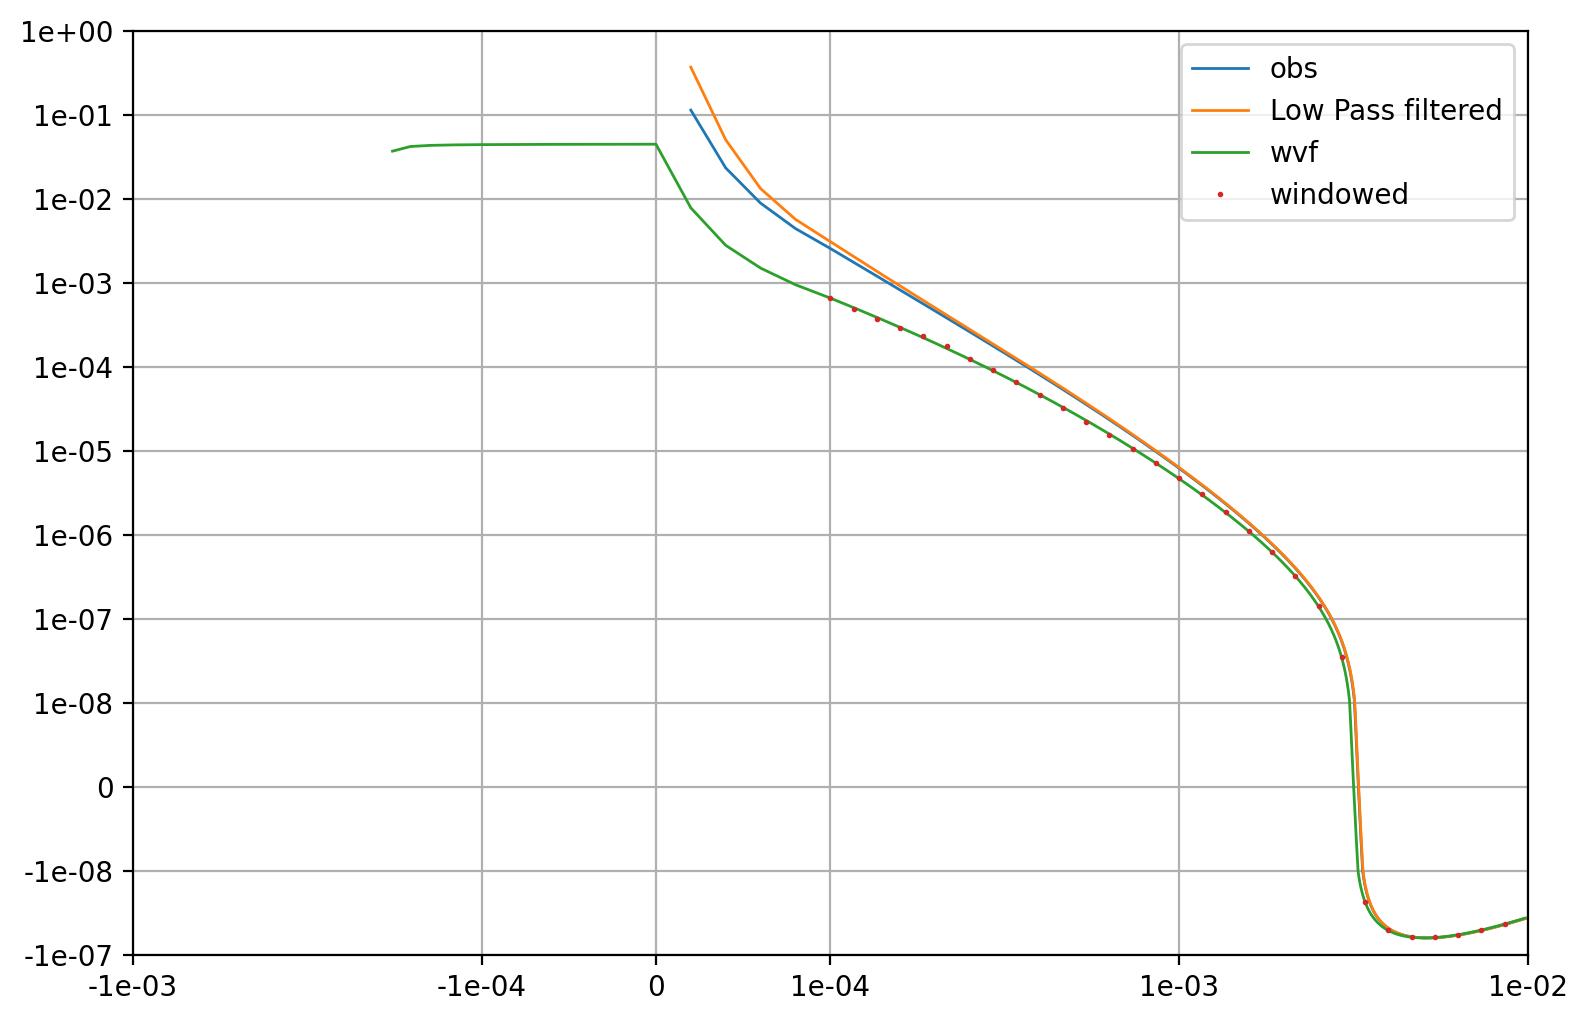

In [ ]:
fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)

ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_step , linestyle="-",label="obs", color="C0",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_LPF , linestyle="-",label="Low Pass filtered", color="C1",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc-rmp_time,y=dpred_rmp , linestyle="-",label="wvf", color="C2",ax=ax)
ax=PL_decay.plpl_plot(
     x= windows_cen-rmp_time,y=dpred_window , marker="o",linestyle="",label="windowed", color="C3",ax=ax)
ax= PL_decay.pl_axes(ax)
ax = PL_decay.pl_axes_x(ax)
#for ax in ax:
ax.grid()
ax.legend()


In [ ]:
relative_error=0.05
data_noise_floor = 1e-8

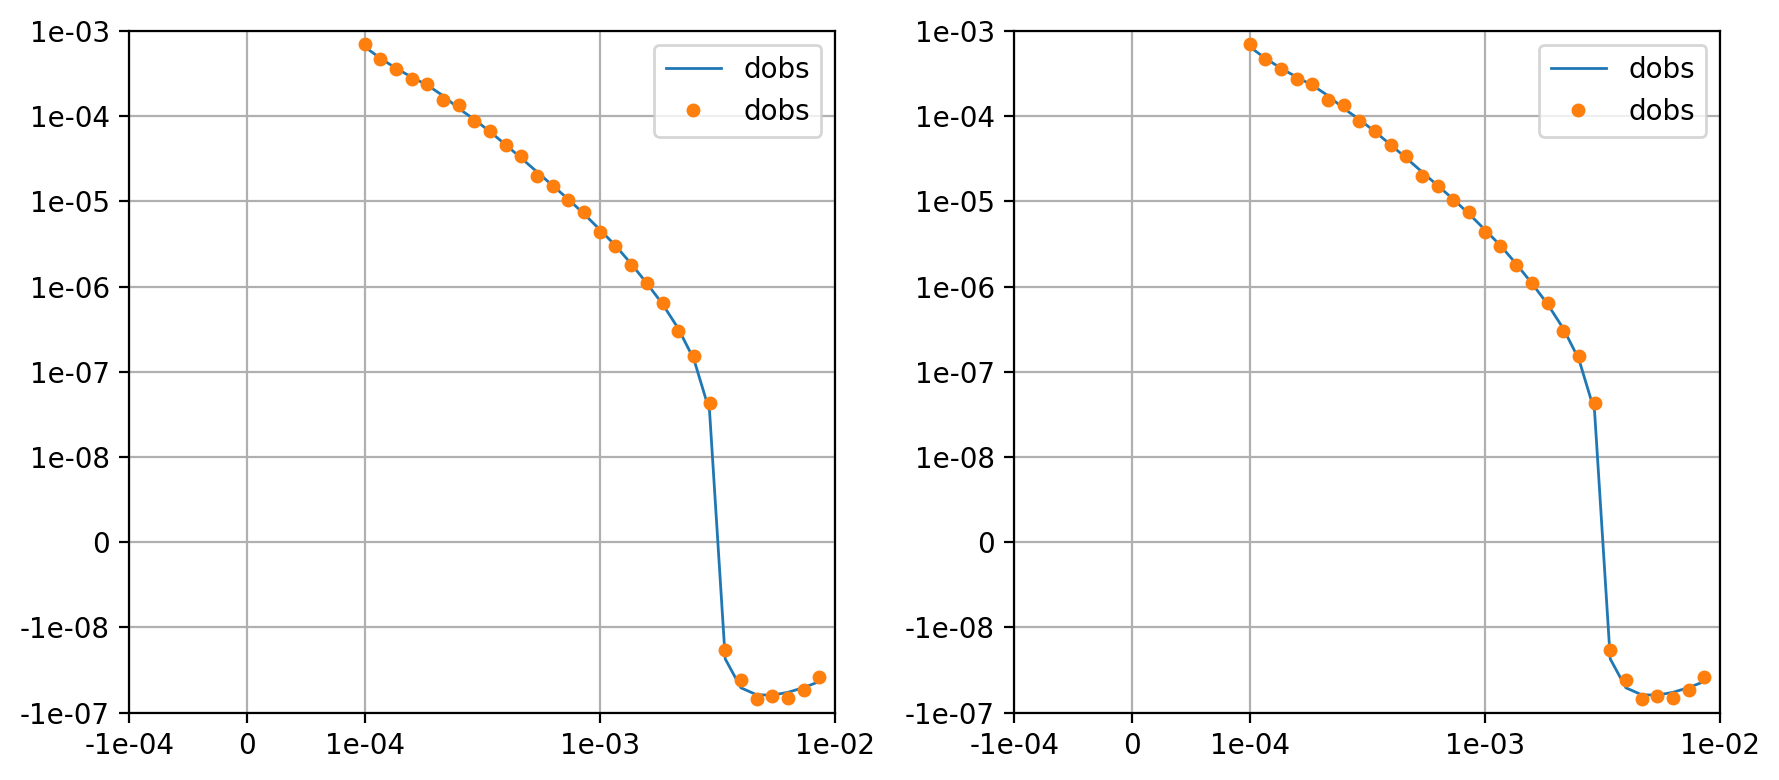

In [ ]:
fig, ax= plt.subplots(1,2, figsize=(9,4), dpi=200)
dobs_cmb =[]
ax= ax.flatten()
for i in range(nmodel):
   np.random.seed(1)
#   np.random.seed(i) 
   mvec_obs = m_trues[i]
   dobs_clean =  sim_obs.dpred(mvec_obs)
   # Calculate noise floor and relative erro at each window
   noise_floor = data_noise_floor
   noise_relative = relative_error * np.abs(dobs_clean)

   # Combine the two sources of noise
   total_noise = np.sqrt(noise_floor**2 + noise_relative**2)

   # Add the combined noise to the clean data
   dobs = dobs_clean +  np.random.randn(len(dobs_clean)) * total_noise
   dobs_cmb.append(dobs)
   ax[i]=PL_decay.plpl_plot(x= windows_cen-rmp_time,y=dobs_clean, 
      label="dobs", color="C0", linestyle="-",ax=ax[i]
   )
   ax[i]=PL_decay.plpl_plot(x= windows_cen-rmp_time,y=dobs, 
      label="dobs", color="C1", marker="o",markersize=4,linestyle="",ax=ax[i]
   )
   ax[i]= PL_decay.pl_axes(ax[i])
   ax[i]= PL_decay.pl_axes_x(ax[i])
#for ax in ax:
   ax[i].grid()
   ax[i].legend()
plt.tight_layout()   

# Invert with Debye Decomposition model

In [ ]:
taus_strt_log = -3.25
taus_end_log  = -2.25
taus_step_logs = np.r_[0.25,0.125]
taus_cmb = []
ntau_cmb = []
for i in range(nmodel):
    ntau = int((taus_end_log - taus_strt_log)/taus_step_logs[i]) +1
    taus= np.logspace(taus_strt_log, taus_end_log, ntau, endpoint=True)
    taus_cmb.append(taus)
    ntau_cmb.append(ntau)
    print(f"Model {i}; ntau: {ntau}, taus: {taus}")

Model 0; ntau: 6, taus: [0.00056234 0.001      0.00177828 0.00316228 0.00562341 0.01      ]
Model 1; ntau: 11, taus: [0.00056234 0.00074989 0.001      0.00133352 0.00177828 0.00237137
 0.00316228 0.00421697 0.00562341 0.00749894 0.01      ]


In [ ]:
# m_ref0 = np.r_[np.log(0.2), np.zeros(ntau)]
# m_ref1 = np.r_[np.log(0.3), np.zeros(ntau)]
# m_ref2 = np.r_[np.log(0.5), np.zeros(ntau)]
# m_refs  = [m_ref0 , m_ref1 , m_ref2 ]
m_refs=[]
rho0_refs = np.r_[0.3, 0.3 , 0.3]
for i in range(nmodel):
    ntau = ntau_cmb[i]
    m_ref = np.r_[np.log(rho0_refs[i]), np.zeros(ntau)]
    m_refs.append(m_ref)
    print(m_ref)


[-1.2039728  0.         0.         0.         0.         0.
  0.       ]
[-1.2039728  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.       ]


In [ ]:
sim_tems = []
for i in range(nmodel):
    taus= taus_cmb[i]
    ntau= ntau_cmb[i]
    sim_tem=empymod_IP_simulation(ip_model='DDR',chgmin=0,
        model_base=empymod_model_sim, nlayer=nlayer,tx_height=tx_height,
        taus=taus, times=times_sim, smp_freq=smp_freq
        )
    sim_tem.deepsea_signle_layer(
        res_sea=res_sea, res_base=res_base, eta_sea=eta_sea, eta_base=eta_base
    )

    m_ref = m_refs[i]
    dpred_step= sim_tem.dpred(m_ref)
    sim_tem.cut_off = smp_freq/2.0
    dpred_LPF = sim_tem.dpred(m_ref)
    sim_tem.filt_curr = filt_linrmp
    dpred_rmp = sim_tem.dpred(m_ref)
    sim_tem.window_mat=Window_mat
    dpred_window = sim_tem.dpred(m_ref)

    sim_tems.append(sim_tem)


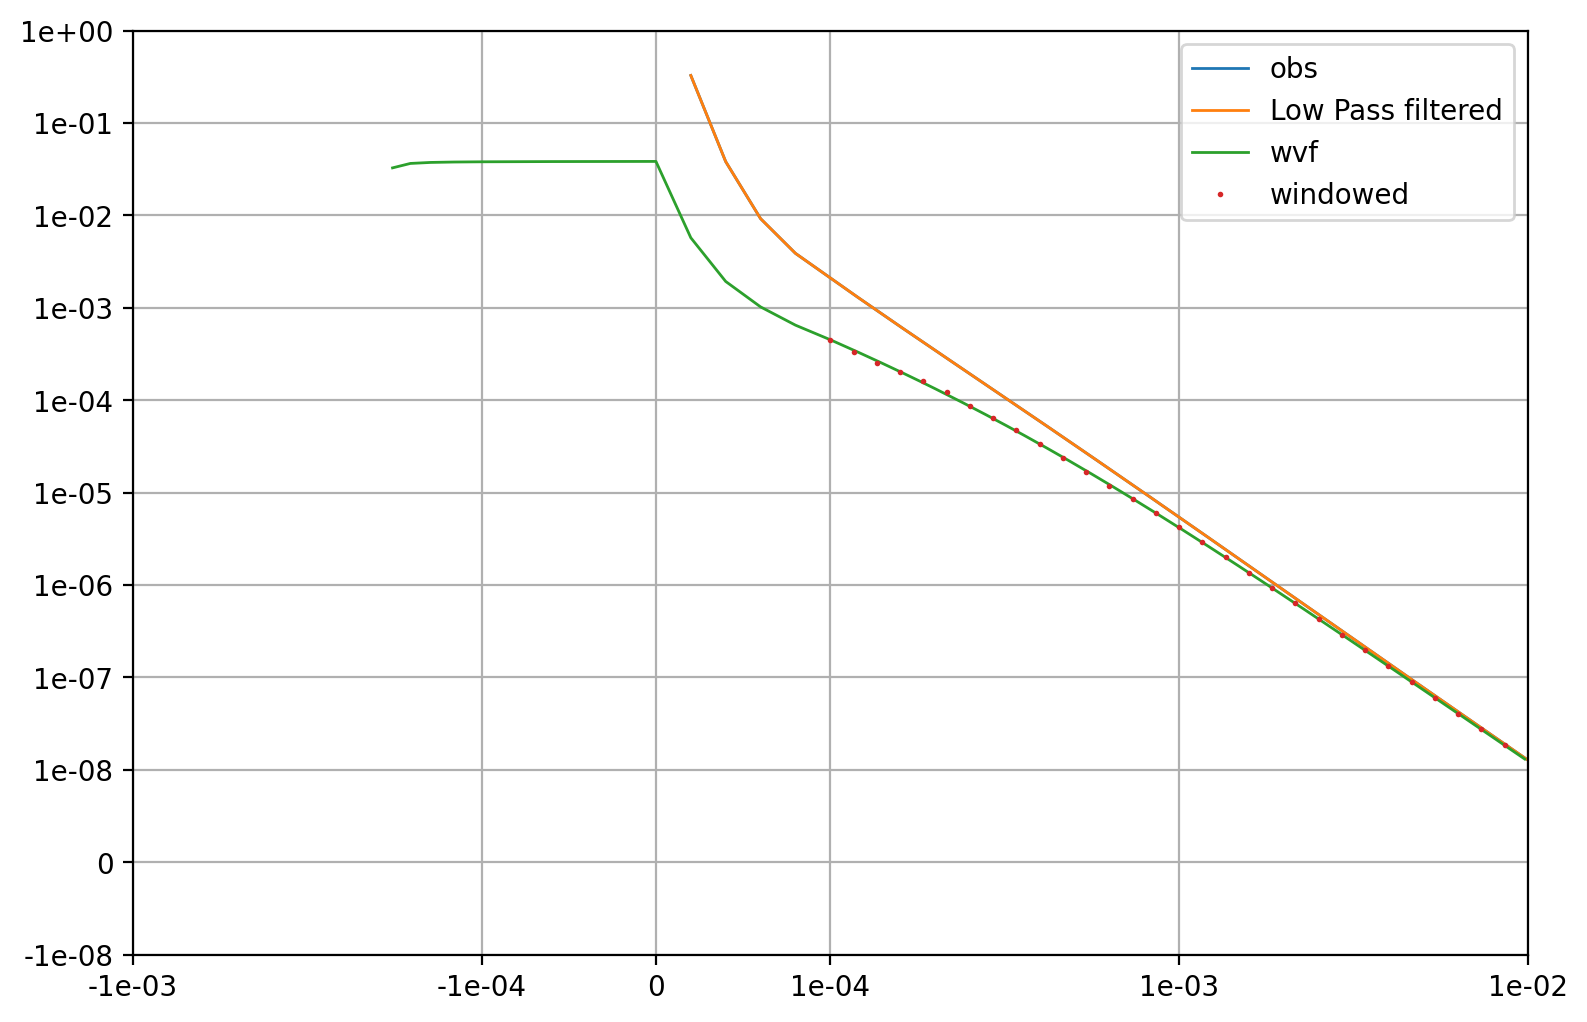

In [ ]:
fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)

ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_step , linestyle="-",label="obs", color="C0",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_LPF , linestyle="-",label="Low Pass filtered", color="C1",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc-rmp_time,y=dpred_rmp , linestyle="-",label="wvf", color="C2",ax=ax)
ax=PL_decay.plpl_plot(
     x= windows_cen-rmp_time,y=dpred_window , marker="o",linestyle="",label="windowed", color="C3",ax=ax)
ax= PL_decay.pl_axes(ax)
ax = PL_decay.pl_axes_x(ax)
#for ax in ax:
ax.grid()
ax.legend()


# Inversion: Single layer fixed thickness

In [ ]:
niter = 40
stol=1e-6
coolingFactor = 2 # np.sqrt(2) #2.0
coolingRate = 2
mu=1e-3
beta0_ratio = 1
Ws_threshold=0.1
alphas= 1.0

In [ ]:
models_rec = []
dpreds = []
error_prgs = []
model_prgs = []
dinit_refs = []
data_prgs =[]
betas_prgs = []
for i in range(nmodel):
    sim_tem = sim_tems[i]  
    dobs = dobs_cmb[i]
    m_ref = m_refs[i]

    opt = Optimization(sim=sim_tem, dobs=dobs, alphas=alphas, Ws_threshold=Ws_threshold)
    opt.get_Wd(ratio=relative_error, plateau=data_noise_floor )
    opt.get_Ws(smallness=np.ones(len(m_ref)))
    beta0 = opt.BetaEstimate_byEig(
        mvec=m_ref, update_Wsen=True, beta0_ratio=beta0_ratio)
    print(beta0)
    mpred = opt.GaussNewton(
    mvec_init=m_ref,niter=niter,beta0=beta0, update_Wsen=True,
    stol=stol,mu=mu,coolingRate=coolingRate, coolingFactor=coolingFactor
    )
    
    dinit_refs.append(opt.dpred(m_ref))
    models_rec.append(mpred)
    dpreds.append(opt.dpred(mpred))
    error_prgs.append(opt.error_prg)
    model_prgs.append(opt.mvec_prg)
    data_prgs.append(opt.data_prg)
    betas_prgs.append(opt.betas)


173321727.07271555
  1, beta:1.7e+08, step:1.0e+00, g:6.4e+04, phid:3.1e+03, phim:1.5e-07, f:3.2e+03 
  2, beta:1.7e+08, step:9.5e-07, g:3.5e+02, phid:3.1e+03, phim:1.5e-07, f:3.2e+03 
  3, beta:8.7e+07, step:1.0e+00, g:3.2e+04, phid:3.0e+03, phim:5.8e-07, f:3.1e+03 
  4, beta:8.7e+07, step:9.5e-07, g:3.4e+02, phid:3.0e+03, phim:5.9e-07, f:3.1e+03 
  5, beta:4.3e+07, step:1.0e+00, g:3.1e+04, phid:2.8e+03, phim:2.2e-06, f:2.9e+03 
  6, beta:4.3e+07, step:9.5e-07, g:6.2e+02, phid:2.8e+03, phim:2.2e-06, f:2.9e+03 
  7, beta:2.2e+07, step:1.0e+00, g:3.1e+04, phid:2.5e+03, phim:7.9e-06, f:2.7e+03 
  8, beta:2.2e+07, step:9.5e-07, g:1.1e+03, phid:2.5e+03, phim:8.2e-06, f:2.7e+03 
  9, beta:1.1e+07, step:1.0e+00, g:3.0e+04, phid:2.0e+03, phim:2.6e-05, f:2.3e+03 
 10, beta:1.1e+07, step:9.5e-07, g:1.5e+03, phid:2.0e+03, phim:2.7e-05, f:2.3e+03 
 11, beta:5.4e+06, step:1.0e+00, g:2.7e+04, phid:1.3e+03, phim:7.0e-05, f:1.7e+03 
 12, beta:5.4e+06, step:9.5e-07, g:1.5e+03, phid:1.3e+03, phim:7.7e-

In [ ]:
phid_star=len(windows_cen)
models_rec_phid = []
dpreds_phid = []
phid_star_ratio =0.9
phid_itrs = []
for i in range(nmodel):
    model_prg= np.array(model_prgs[i])
    data_prg = np.array(data_prgs[i])
    error_prg = error_prgs[i]
    phid_prg = np.array(error_prg)[:,1]
    ind = phid_prg < phid_star*phid_star_ratio
    if np.sum(ind) == 0:
        ind = phid_prg == np.min(phid_prg)
        print("no iteration found ")
    phid_itr = np.where(ind)[0][0]
    models_rec_phid.append(model_prg[ind][0])
    dpreds_phid.append(data_prg[ind][0])
    phid_itrs.append(phid_itr)


no iteration found 
no iteration found 


In [ ]:
models_rec_phid

[array([-1.49898767,  0.01367451,  0.00850978,  0.0036434 ,  0.02671954,
         0.04308643,  0.03326534]),
 array([-1.49844458,  0.01237164,  0.00340565,  0.00469519,  0.00191044,
         0.00199337,  0.006548  ,  0.01319452,  0.01856735,  0.0205328 ,
         0.02038372,  0.02511836])]

In [ ]:
print( "Parameter:  $\\rho_0$, $\\eta$, $\\tau_max$")
np_mvec_ests= []

for i in range(nmodel):
    # mvec_est = models_rec[i]
    np_mvec_ref = m_refs[i]

    mvec_est = models_rec_phid[i]
    np_mvec_ests.append(mvec_est)
    print(f"ref{i+1}     & {np.exp(np_mvec_ref[0]):.2e} & {np_mvec_ref[1:].sum():.3f} ")
    print(f"est{i+1}     & {np.exp(mvec_est[0]):.2e} & { mvec_est[1:].sum():.3f}")


Parameter:  $\rho_0$, $\eta$, $\tau_max$
ref1     & 3.00e-01 & 0.000 
est1     & 2.23e-01 & 0.129
ref2     & 3.00e-01 & 0.000 
est2     & 2.23e-01 & 0.129


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


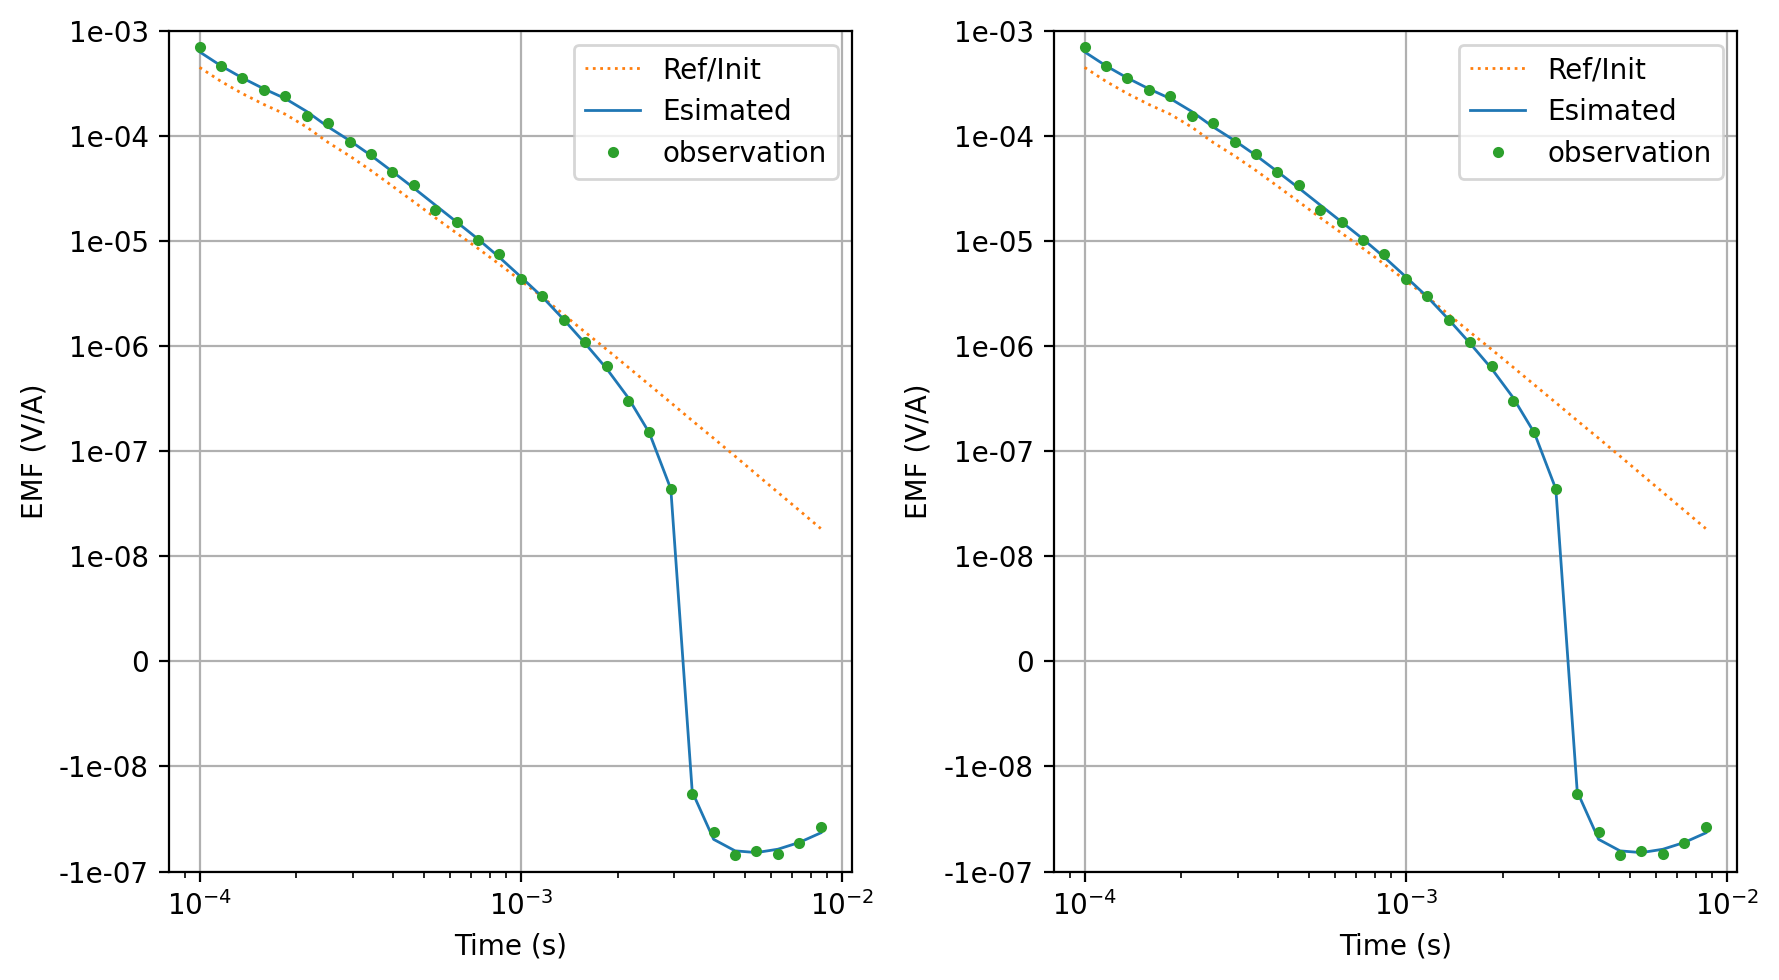

In [ ]:
fig, ax= plt.subplots(1,nmodel, figsize=(9,5), dpi=200)
ax= ax.flatten()
for i in range(nmodel):
    dobs= dobs_cmb[i]   
    dinit_ref = dinit_refs[i]

    ax[i]=PL_decay.semiply(
        windows_cen-rmp_time, dinit_ref, ax=ax[i],
        color=f"C1",linestyle=":", label=f"Ref/Init"
        )

    ax[i]=PL_decay.semiply(
        windows_cen-rmp_time, dpreds_phid[i], ax=ax[i],
        color=f"C0",linestyle="-", label=f"Esimated"
        )
    ax[i]=PL_decay.semiply(
        windows_cen-rmp_time, dobs, ax=ax[i], marker="o",markersize=3.0,
        color=f"C2",linestyle="", label="observation"
        )
    ax[i] = PL_decay.pl_axes(ax[i])
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("EMF (V/A)")
plt.tight_layout()

# get SIP of target layer

In [ ]:
freq_step_log  = 0.1
nfreq = int((taus_end_log - taus_strt_log)/freq_step_log) +1
print(nfreq)
freq = np.logspace(
    -taus_end_log, -taus_strt_log, nfreq, endpoint=True
    ) 
freq /= 2.0*np.pi
freq_min = freq.min()
freq_max = freq.max()
print(f"freq min {freq.min():.2e}, max {freq.max():.2e}" )

freq_ext = 10.**np.arange(-1,5.1,0.1)

13
freq min 1.59e+01, max 2.83e+02


In [ ]:
# relative_error = 0.07
noise_floor_ratio = 1e-4
niter = 100
stol=1e-6
coolingFactor = 2 # np.sqrt(2) 
coolingRate = 2
mu=1e-3
beta0_ratio = 1.0

In [ ]:
sip_true =[]
sip_true_ext = []
sip_dpreds = []
sip_dpreds_ext = []
sim_sip_dd = []
sim_sip_dd_ext = []
sim_sip_pel = []
sim_sip_pel_ext = []
model_recs_sip = []
error_prgs_sip = []
model_prgs_sip = []
data_prgs_sip =[]
betas_prgs_sip = []
for i in range(nmodel):
    
    IP_model = Pelton_res_f(freq=freq)
    sim_sip = InducedPolarizationSimulation(ip_model=IP_model, mode='sip')
    sim_sip_pel.append(sim_sip)
    mvec_obs = m_trues[i]

    dobs = sim_sip.dpred(m=mvec_obs)
    sip_true.append(dobs)
    f_abs = abs(IP_model.f(mvec_obs))
    noise_floor= f_abs.max()*noise_floor_ratio

    IP_model = Pelton_res_f(freq=freq_ext)
    sim_sip = InducedPolarizationSimulation(ip_model=IP_model, mode='sip')
    sim_sip_pel_ext.append(sim_sip)

    taus= taus_cmb[i]

    IP_model = DDR_f(freq=freq_ext,taus=taus)
    sim = InducedPolarizationSimulation(ip_model=IP_model, mode='sip')
    sim_sip_dd_ext.append(sim)

    IP_model = DDR_f(freq=freq,taus=taus)
    sim = InducedPolarizationSimulation(ip_model=IP_model, mode='sip')
    sim_sip_dd.append(sim)

    m_ref = m_refs[i]   
    
    opt = Optimization(sim=sim, dobs= dobs)
    opt.get_Wd(ratio=relative_error, plateau=noise_floor)
    opt.get_Ws(np.ones(len(m_ref)))
    beta0 = opt.BetaEstimate_byEig(mvec=m_ref, update_Wsen=True)
    mpred = opt.GaussNewton(
        mvec_init=m_ref,niter=niter,beta0=beta0, update_Wsen=True,
        stol=stol,mu=mu,coolingRate=coolingRate, coolingFactor=coolingFactor
        )
    model_recs_sip.append(mpred)
    error_prgs_sip.append(opt.error_prg)
    model_prgs_sip.append(opt.mvec_prg)
    data_prgs_sip.append(opt.data_prg)
    betas_prgs_sip.append(opt.betas)

  1, beta:2.8e+08, step:1.0e+00, g:1.3e+05, phid:6.6e+03, phim:1.8e-07, f:6.6e+03 
  2, beta:2.8e+08, step:1.6e-02, g:1.8e+02, phid:6.6e+03, phim:1.8e-07, f:6.6e+03 
  3, beta:1.4e+08, step:1.0e+00, g:6.4e+04, phid:6.4e+03, phim:7.1e-07, f:6.5e+03 
  4, beta:1.4e+08, step:1.6e-02, g:1.7e+02, phid:6.4e+03, phim:7.1e-07, f:6.5e+03 
  5, beta:6.9e+07, step:1.0e+00, g:6.3e+04, phid:6.0e+03, phim:2.6e-06, f:6.2e+03 
  6, beta:6.9e+07, step:1.6e-02, g:3.1e+02, phid:6.0e+03, phim:2.6e-06, f:6.2e+03 
  7, beta:3.5e+07, step:1.0e+00, g:6.0e+04, phid:5.4e+03, phim:9.2e-06, f:5.7e+03 
  8, beta:3.5e+07, step:7.8e-03, g:5.2e+02, phid:5.4e+03, phim:9.2e-06, f:5.7e+03 
  9, beta:1.7e+07, step:1.0e+00, g:5.6e+04, phid:4.5e+03, phim:2.9e-05, f:5.0e+03 
 10, beta:1.7e+07, step:9.5e-07, g:7.6e+02, phid:4.5e+03, phim:2.9e-05, f:5.0e+03 
 11, beta:8.6e+06, step:1.0e+00, g:4.9e+04, phid:3.3e+03, phim:7.8e-05, f:4.0e+03 
 12, beta:8.6e+06, step:9.5e-07, g:9.1e+02, phid:3.3e+03, phim:7.8e-05, f:4.0e+03 
 13,

In [ ]:
phid_star_ratio = 1.1
sip_true_inv = []
for i in range(nmodel):
    phid_star = nfreq*2
    model_prg= np.array(model_prgs_sip[i])
    data_prg = np.array(data_prgs_sip[i])
    error_prg = error_prgs_sip[i]
    phid_prg = np.array(error_prg)[:,1]
    ind = phid_prg < phid_star*phid_star_ratio
    if np.sum(ind) == 0:
        ind = phid_prg == np.min(phid_prg)
        print(f" range {i}:No phid star found, take min phid")
    model = model_prg[ind][0]
    sip_true_inv.append(model_prg[ind][0])
    rho0_sip = np.exp(model[0])
    eta_sip = model[1:].sum()
    print(f"Model {i}: rho0: {rho0_sip:.2e}, eta: {eta_sip:.3f}")
 

Model 0: rho0: 2.28e-01, eta: 0.163
Model 1: rho0: 2.27e-01, eta: 0.164


In [ ]:
sip_true_inv

[array([-1.47960817,  0.01485397,  0.01002963,  0.007354  ,  0.01202394,
         0.03476586,  0.08363944]),
 array([-1.48401204,  0.01070111,  0.00835164,  0.00615933,  0.00404854,
         0.00227177,  0.00156607,  0.003215  ,  0.00883972,  0.01989271,
         0.0372257 ,  0.06131478])]

In [ ]:
def plot_data(iteration, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
       
    ax=PL_decay.semiply(windows_cen-rmp_time, data_init, ax=ax,
                       color="C1",label="Ref"
                       )
    ax=PL_decay.semiply(windows_cen-rmp_time, dpreds, ax=ax
                        ,color="C0",linestyle="-",
                        label=f"Est" #, iter={iteration}"
                        )
    ax=PL_decay.semiply(windows_cen-rmp_time, dobs, ax=ax, marker="o",markersize=3.0,
                       color="C2",linestyle="", label="Obs"
                       )
    ax = PL_decay.pl_axes(ax)
    # ax.grid()
    # ax.legend()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("EMF (V/A)")
    ax.set_title(f""" Data plot
Relative error {relative_error*100:.1f} %, noise floor {data_noise_floor:.1e} V/A""")
    return ax

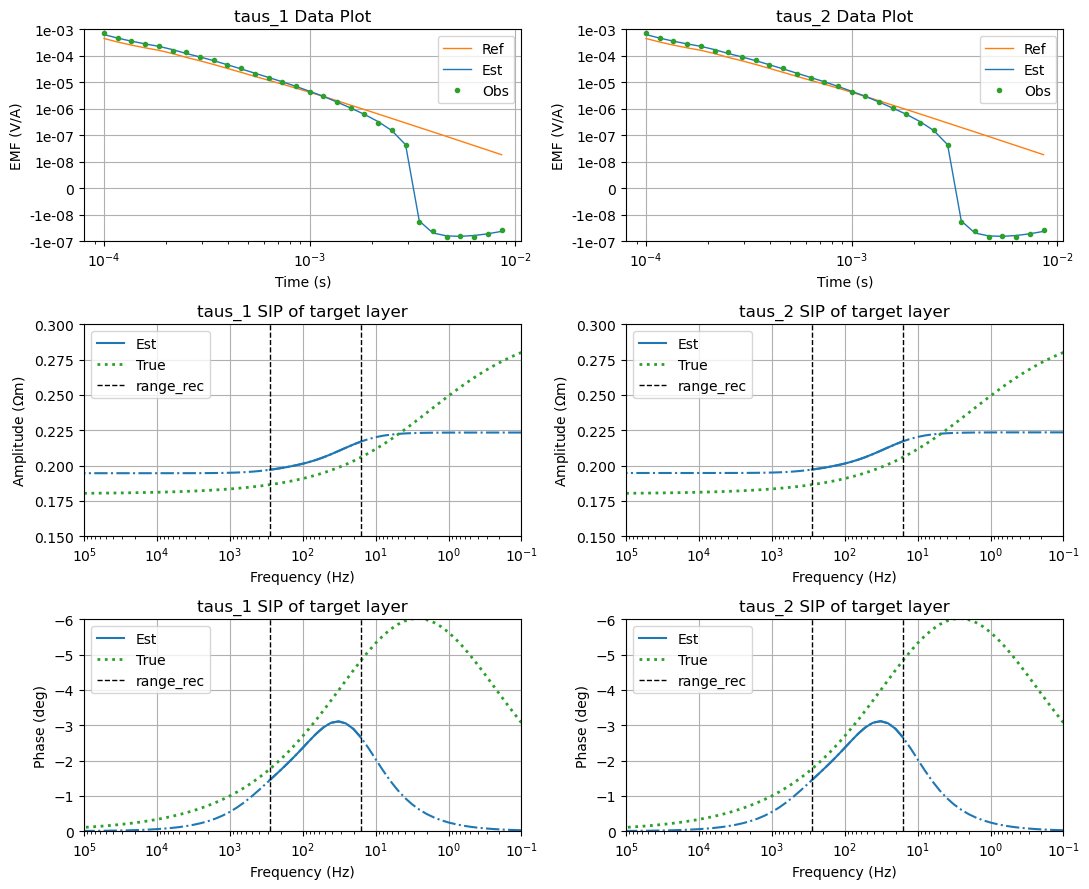

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(11,9))
# title_heads = ["noise_0", "noise_1", "noises_2"]
title_heads = ["taus_1", "taus_2"]
ax_ranges = []
for i in range(nmodel):
    ax_ranges.append([ax[0, i], ax[1, i], ax[2, i]])

for i in range(nmodel):
    title_head = title_heads[i]
    phid_itr = phid_itrs[i]
    data_init = dinit_refs[i]
    dpreds = dpreds_phid[i]
    dobs= dobs_cmb[i]
    m_dd = models_rec_phid[i]
    ax_range = ax_ranges[i]
    axdata = ax_range[0]
    axdata = plot_data(iteration=phid_itr, ax=axdata)
    axsip = [ax_range[1], ax_range[2]]
    sim = sim_sip_dd_ext[i]
    axsip = sim.plot_sip_model(
        m_dd, ax=axsip, color="C0", linestyle="-."
        )
    sim = sim_sip_dd[i]
    axsip = sim.plot_sip_model(
        m_dd, ax=axsip, color="C0", label=f"Est", linestyle="-"
        )
           
    # axsip = plot_sip(freq_ext, sip_dpreds_ext[i], 
    #          ax=axsip, color="C0", label=f"Est", linestyle="-.")
    # axsip = plot_sip(freq, sip_dpreds[i], 
    #          ax=axsip, color="C0", label=f"Est", linestyle="-"
            #  )
    # axsip = plot_sip(freq, sip_true_dpred[i], 
    #          ax=axsip, color="C1", label=f"Estimated by sip", linestyle="-"
    #          )
    sim = sim_sip_pel_ext[i]
    axsip = sim.plot_sip_model(
        m_trues[i], ax=axsip, color="C2", label=f"True", linestyle=":",
        linewidth=2.0
    )   
    # axsip  = plot_sip(freq=freq_ext,
    #           dpreds=sip_true_ext[i],ax=axsip, color="C2", label=f"True", linestyle=":",
    #           linewidth=2.0)
    axsip[0].set_ylim(bottom=0.15,top=0.3)
    axsip[1].set_ylim(top=-6, bottom=0)
    axsip[0].axvline(x=freq_min, color='k', linestyle='--', linewidth=1.0,
                     label=f"range_rec"
                     )
    axsip[0].axvline(x=freq_max, color='k', linestyle='--', linewidth=1.0)
    axsip[1].axvline(x=freq_min, color='k', linestyle='--', linewidth=1.0,
                     label=f"range_rec"
                     )
    axsip[1].axvline(x=freq_max, color='k', linestyle='--', linewidth=1.0)

    for a in axsip:
        a.set_xlim(left=1e5, right=0.1)
        # a.set_ylim(left=1e3, right=1)
        
    for a in ax_range:
        a.legend()
        a.grid()

    ax_range[0].set_title(f"{title_head} Data Plot")
    ax_range[1].set_title(f"{title_head} SIP of target layer")
    ax_range[2].set_title(f"{title_head} SIP of target layer")

plt.tight_layout()
plt.savefig('45_DD_data_10msec.jpg', dpi=300)

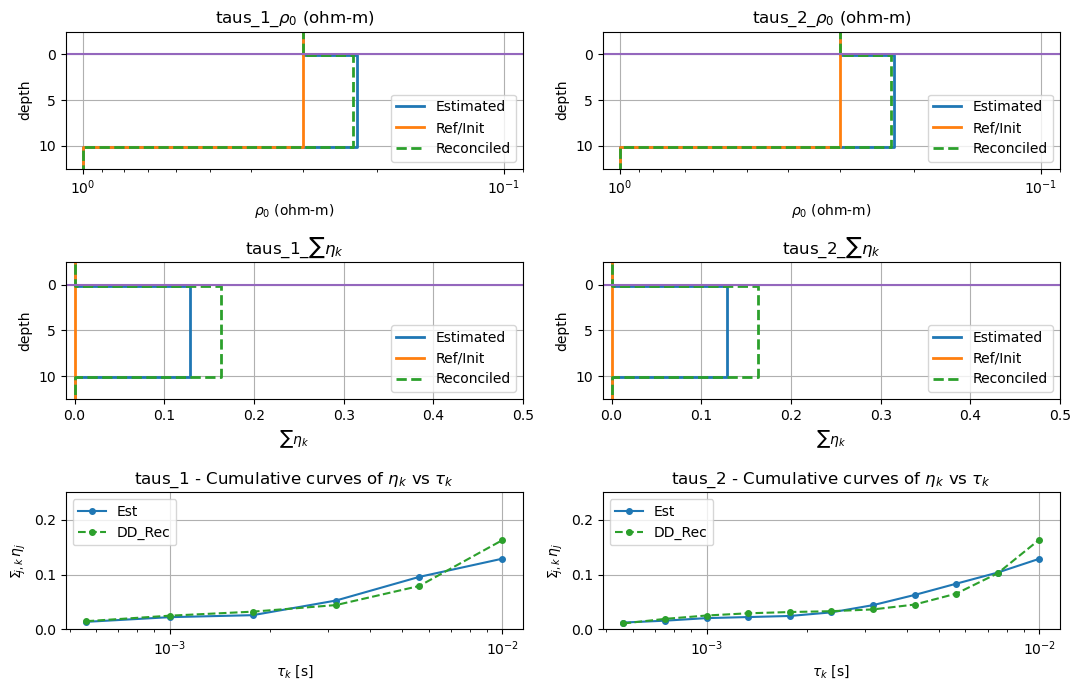

In [ ]:
fig, ax = plt.subplots(3, nmodel, figsize=(11,7))
ax_range = []
for i in range(nmodel):
    ax_range.append([ax[0, i], ax[1, i], ax[2, i]])

for i in range(nmodel):
    sim_tem = sim_tems[i]
    sim_sip = sim_sip_dd[i]
    taus= taus_cmb[i]
    title_head = title_heads[i]
    m_tem = models_rec_phid[i]
    m_ref = m_refs[i]
    m_sip = sip_true_inv[i] 
    m_true = sip_true_inv[i]

    axtmp  = ax_range[i]
    axrm   = ax_range[i][0:2]
    axetas = ax_range[i][2]
    axrm = sim_tem.plot_IP_par(mvec=m_tem, rm=True,
            label="Estimated", color=f"C0", linestyle="-", 
            ax=axrm, linewidth=2.0)
    rho0,eta = sim_sip.ip_model.get_rho_eta(m_tem)
    label = fr"est_$\rho_0$: {rho0: .1e}, $\eta$: {eta: .2f}"
    
    axetas = sim_sip.ip_model.plot_etas_cum(mvec=m_tem,
             ax=axetas, color="C0",
             label="Est",
             linestyle="-", marker='o', markersize=4
             )
    
    axrm = sim_tem.plot_IP_par(mvec=m_ref, rm=True, 
            label="Ref/Init", color=f"C1", linestyle="-",
            ax=axrm, linewidth=2.0)

    # label = fr"est_$\rho_0$: {rho0: .1e}, $\eta$: {eta: .2f}"

    axrm = sim_tem.plot_IP_par(mvec=m_true, rm=True, 
            label="Reconciled", color=f"C2", linestyle="--",
            ax=axrm, linewidth=2.0)
    # rho0,eta = sim.ip_model.get_rho_eta(sip_true_inv[i])
    # label = fr"tru_$\rho_0$: {rho0: .1e}, $\eta$: {eta: .2f}"
    axetas = sim_sip.ip_model.plot_etas_cum(mvec=m_sip,
             ax=axetas, color="C2", label="DD_Rec",
            linestyle="--", marker='o', markersize=4
             )
    axrm[0].set_xlim([1.1,0.09])
    axrm[1].set_xlim([-0.01,0.5])
    axetas.set_ylim([0, 0.250])
    for a in (axtmp):
        a.grid()
        a.legend()
        # if j >= 2:  # Only show legend for ax[2] and ax[3]
        #     a.legend(loc='upper left', fontsize='small')

    for j , a in enumerate(axrm):  # Iterate over rows
        a.axhline(empymod_model_sim["src"][4], color=f"C4", linestyle="-", label="Src+Rec")
        a.set_ylim([12.5, -2.5])
        a.set_ylabel('depth')
        if j== 0 :
            a.set_xscale("log")
        else:
            a.set_xscale("linear")
    axrm[0].set_title(fr"{title_head}_$\rho_0$ (ohm-m)")
    axrm[1].set_title(fr"{title_head}_$\sum\eta_k$")
    axetas.set_title(fr"{title_head} - Cumulative curves of $\eta_k$ vs $\tau_k$")

# ax_right = [ax[0,3], ax[1,3], ax[2,3]]
# for a in ax_right:
#     a.axis("off")
# handles, labels = axtmp[1].get_legend_handles_labels()
# ax[1,3].legend(handles, labels)

# handles, labels = axtmp[2].get_legend_handles_labels()
# ax[2,3].legend(handles, labels)

plt.tight_layout()
plt.savefig('45_Recovered_10msec.jpg', dpi=300)

In [ ]:
def plot_each_data(data, ax=None, **kwargs):
    default_kwargs = {
        "linestyle": "-",
        "color": "C0",
        "linewidth": 1.0,
        "marker": None,
        "markersize": 1,
    }
    default_kwargs.update(kwargs)
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
       
    ax=PL_decay.semiply(windows_cen-rmp_time, data, ax=ax,
                       **default_kwargs
                       )
    ax = PL_decay.pl_axes(ax)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("EMF (V/A)")
    ax.set_title(f""" Data plot
Relative error {relative_error*100:.1f} %, noise floor {data_noise_floor:.1e} V/A""")
    return ax

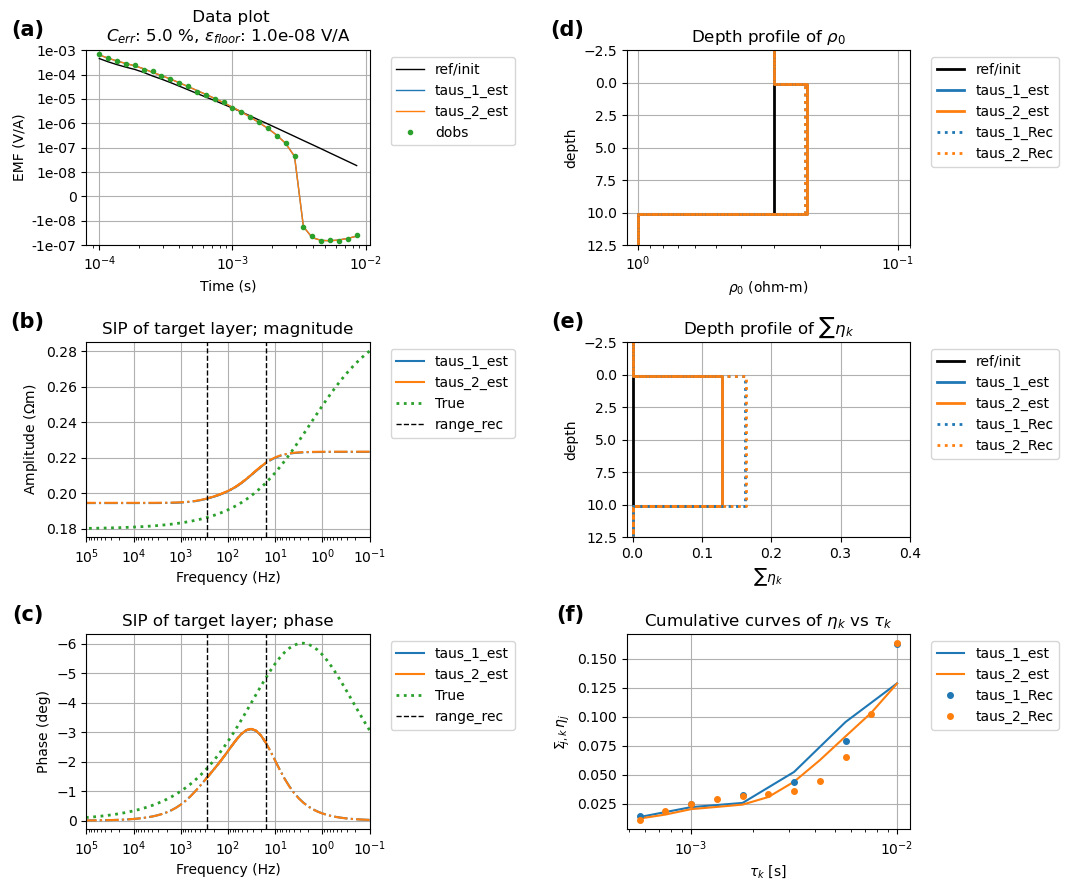

In [ ]:
fig,ax = plt.subplots(3,2,figsize=(11, 9))
ax =ax.flatten()
axdata = ax[0]
axsip = [ax[2], ax[4]]
axmodel = [ax[1], ax[3]]
axetas = ax[5]
data_init = dinit_refs[0]

axdata = plot_each_data(data=data_init,
            label=f"ref/init",color=f"k", 
            ax=axdata)
m_ref = m_refs[0]
sim_tem = sim_tems[0]
axmodel= sim_tem.plot_IP_par(mvec=m_ref, rm=True,
    label="ref/init", color="k", linestyle="-", 
    ax=axmodel, linewidth=2.0)

for i in range(nmodel):
    taus= taus_cmb[i]   
    sim_tem = sim_tems[i]
    sim_sip = sim_sip_dd[i]
    sim_sip_ext = sim_sip_dd_ext[i]
    title_head = title_heads[i]
    dpreds = dpreds_phid[i]
    m_tem = models_rec_phid[i]
    m_sip = sip_true_inv[i]

    ax_range = ax_ranges[i]
    axdata = plot_each_data(data=dpreds,
             label=f"{title_head}_est",color=f"C{i}", 
             ax=axdata)
    axsip = sim_sip_ext.plot_sip_model(
        m_tem, ax=axsip, color=f"C{i}", linestyle="-."
        )
    axsip = sim_sip.plot_sip_model(
        m_tem, ax=axsip, color=f"C{i}", label=f"{title_head}_est", linestyle="-"
        )

    # axsip = sim_sip.plot_sip_model( 
    #          m_sip, ax=axsip, color=f"C{i+3}", linestyle="-."
    #          )

    axmodel= sim_tem.plot_IP_par(mvec=m_tem, rm=True, 
        label=f"{title_head}_est", color=f"C{i}", linestyle="-", 
        ax=axmodel, linewidth=2.0)

    axetas = sim_sip.ip_model.plot_etas_cum(mvec=m_tem,
             ax=axetas, color=f"C{i}",
             label=f"{title_head}_est",
             linestyle="-",
                )

dobs= dobs_cmb[0]
axdata = plot_each_data(data=dobs,
            label=f"dobs",color=f"C{nmodel}", 
            linestyle="", marker="o", markersize=3.0,
            ax=axdata)

# axsip  = plot_sip(freq=freq_ext,
#             dpreds=sip_true_ext[0],ax=axsip,
#             color=f"C{nmodel}", label=f"True",
#             linestyle="-.", alpha=0.7)

sim = sim_sip_pel_ext[0]
axsip = sim.plot_sip_model(
    m_trues[0], ax=axsip, color=f"C{nmodel}", label=f"True",
    linestyle=":", linewidth=2.0
)
# axsip  = plot_sip(freq=freq,
#             dpreds=sip_true[0],ax=axsip,
#             color=f"C{nmodel}", label=f"True_FB")


for i in range(nmodel):
    sim_tem = sim_tems[i]
    sim_sip = sim_sip_dd[i] 
    taus= taus_cmb[i]
    ntau= ntau_cmb[i]
    title_head = title_heads[i]
    m_true = sip_true_inv[i]
    axmodel = sim_tem.plot_IP_par(mvec=m_true, rm=True, 
                label=f"{title_head}_Rec", color=f"C{i}", linestyle=":",
                ax=axmodel, linewidth=2.0)          
    axetas = sim_sip.ip_model.plot_etas_cum(mvec=m_true,
                ax=axetas, color=f"C{i}", label=f"{title_head}_Rec",
                linestyle="", marker='o', markersize=4
                )

for a in axsip:
    a.set_xlim(left=1e5, right=0.1)


# axsip[0].set_ylim(bottom=0.15,top=0.3)
axsip[0].axvline(x=freq_max, color='k', linestyle='--', linewidth=1.0)
axsip[0].axvline(x=freq_min, color='k', linestyle='--', linewidth=1.0,
                    label=f"range_rec"
                    )
axsip[1].invert_yaxis()
# axsip[1].set_ylim(top=-8, bottom=0)
axsip[1].axvline(x=freq_min, color='k', linestyle='--', linewidth=1.0,
                    label=f"range_rec"
                    )
axsip[1].axvline(x=freq_max, color='k', linestyle='--', linewidth=1.0)

axdata.set_title(fr""" Data plot
$C_{{err}}$: {relative_error*100:.1f} %, $\epsilon_{{floor}}$: {data_noise_floor:.1e} V/A""")

axsip[0].set_title(f"SIP of target layer; magnitude")
axsip[1].set_title(f"SIP of target layer; phase")

axmodel[0].set_xlim([1.1,0.09])
axmodel[1].set_xlim(right = 0.40)  #([-0.02,0.42])
# axetas.set_ylim([0, 0.25])
axmodel[0].set_title(r"Depth profile of $\rho_0$")
axmodel[1].set_title(r"Depth profile of $\sum\eta_k$")
axetas.set_title(r"Cumulative curves of $\eta_k$ vs $\tau_k$")


for j , a in enumerate(axmodel):  # Iterate over rows
    # a.axhline(empymod_model_sim["src"][4], color=f"C4", linestyle="-", label="Src+Rec")
    a.set_ylim([12.5, -2.5])
    a.set_ylabel('depth')
    if j== 0 or j==2:
        a.set_xscale("log")
    else:
        a.set_xscale("linear")

for a in ax:
    a.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # a.legend()
    a.grid()

panel_labels = ['(a)', '(d)', '(b)', '(e)', '(c)', '(f)']

for label, axis in zip(panel_labels, ax):
    axis.text(
        -0.15, 1.05, label,
        transform=axis.transAxes,
        fontsize=15, fontweight='bold',
        va='bottom', ha='right'
    )

plt.tight_layout()
plt.savefig('45_DD_2taus.jpg', dpi=300)
plt.savefig("45_DD_2taus.pdf", bbox_inches="tight")

print latex code for table

In [ ]:
file_path = "43_inv_result.json"
with open(file_path, "r") as f:
    data_43 = json.load(f)

JSONDecodeError: Expecting value: line 1 column 14 (char 13)

In [ ]:
sip_inv_43 = data_43["sip_inv"]
tem_inv_43 = data_43["tem_inv"]
ntau_cmb_43 = data_43["ntau_cmb"]
freq_maxs_43 = data_43["freq_maxs"]
freq_mins_43 = data_43["freq_mins"]
taus_end_43 = data_43["taus_end"]
taus_strt_43 = data_43["taus_strt"]

In [ ]:
sip_inv_print=[]
sip_inv_print.append(sip_inv_43[0])
sip_inv_print.append(sip_true_inv[0])
sip_inv_print.append(sip_true_inv[1])
sip_inv_print.append(sip_inv_43[2])
tem_inv_print=[]
tem_inv_print.append(tem_inv_43[0])
tem_inv_print.append(models_rec_phid[0])
tem_inv_print.append(models_rec_phid[1])
tem_inv_print.append(tem_inv_43[2])
ntau_print=[]
ntau_print.append(ntau_cmb_43[0])
ntau_print.append(ntau_cmb[0])
ntau_print.append(ntau_cmb[1])
ntau_print.append(ntau_cmb_43[2])

taurange_print = []
freqrange_print = []
for i in range(3):
    taurange_print.append(np.r_[taus_strt_43[i], taus_end_43[i]])
    freqrange_print.append(np.r_[freq_mins_43[i], freq_maxs_43[i]])


In [ ]:
rho0_print =[]
eta_print =[]


for i in range(4):
    model = np.array(tem_inv_print[i])
    rho0 = np.exp(model[0])
    eta = model[1:].sum()
    rho0_print.append(rho0)
    eta_print.append(eta)

    model = np.array(sip_inv_print[i])
    rho0 = np.exp(model[0])
    eta = model[1:].sum() 
    rho0_print.append(rho0)
    eta_print.append(eta)




In [ ]:
def sci_latex(v, prec=2):
    s = f"{v:.{prec}e}"          # e.g. '3.00e-03'
    mant, exp = s.split('e')     # '3.00', '-03'
    exp = int(exp)               # remove leading zeros
    if float(mant) == 0:
        return "0"
    if exp == 0:
        return f"{mant}"
    if exp != 0:
        return rf"${mant}\cdot 10^{{{exp}}}$"


In [ ]:
print(r" frequency band & \multicolumn{2}{c|}{"
      + r"} & \multicolumn{2}{c|}{".join(
          " to ".join(sci_latex(v, prec=1) for v in z)
          for z in freqrange_print
      )
       + r"} \\"
)


print(r" $\tau_k$ band & \multicolumn{2}{c|}{"
      + r"} & \multicolumn{2}{c|}{".join(
          " to ".join(sci_latex(v, prec=1) for v in z)
          for z in taurange_print
      )
       + r"} \\"
)



print("\hline")


print(" n & "
      +" & ".join(f"{v: }" for v in ntau_print
      )
       + r"\\"
)


print(r"$\rho_0$ & "
      +" & ".join(f"{v: .2f}" for v in  rho0_print)
       + r"\\"
)

print(r"$\sum\eta_k$ & "
      +" & ".join(f"{v:.2f}" for v in eta_print)
     + r"\\"
)



\hline
 n &  3 &  5 &  9 &  10\\
$\rho_0$ &  0.218 &  0.208 &  0.220 &  0.218 &  0.220 &  0.217 &  0.295 &  0.269\\
$\sum\eta_k$ & 0.059 & 0.084 & 0.117 & 0.134 & 0.114 & 0.135 & 0.331 & 0.270\\
